#**Modelagem - Predição de Churn para Empresa de Telecomunicação**

Após a etapa de preparação e seleção de variáveis, os dados estão prontos para a fase de modelagem preditiva. O objetivo desta etapa é construir e avaliar diferentes algoritmos de machine learning capazes de prever a probabilidade de um cliente cancelar o serviço (churn).

A modelagem desempenha papel central no projeto, pois permite transformar os dados tratados em conhecimento acionável. Por meio dela, é possível identificar padrões de evasão, estimar riscos individuais de cancelamento e, consequentemente, fornecer subsídios para que a empresa adote estratégias proativas de retenção.

**1. Importar bibliotecas e definir funções**



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, roc_auc_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Esse conjunto de funções implementa um framework completo de avaliação de modelos preditivos, reunindo métricas estatísticas e representações gráficas para analisar o desempenho tanto em treino quanto em teste.

In [ ]:
def avaliar_modelo(X_train, y_train, X_test, y_test, modelo, nm_modelo):
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    import itertools
    from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, roc_auc_score

    feature_names = list(X_train.columns)
    # Criação da figura e dos eixos
    fig, axs = plt.subplots(5, 2, figsize=(15, 30))  # Ajustado para incluir novos gráficos
    plt.tight_layout(pad=6.0)

    # Cor azul claro
    cor = 'skyblue'

    # Taxa de Evento e Não Evento
    event_rate = np.mean(y_train)
    non_event_rate = 1 - event_rate
    axs[0, 0].bar(['Evento', 'Não Evento'], [event_rate, non_event_rate], color=[cor, 'lightcoral'])
    axs[0, 0].set_title('Taxa de Evento e Não Evento')
    axs[0, 0].set_ylabel('Proporção')

    # Importância dos Atributos
    importancias = None
    if hasattr(modelo, 'coef_'):
        importancias = np.abs(modelo.coef_[0])
    elif hasattr(modelo, 'feature_importances_'):
        importancias = modelo.feature_importances_

    if importancias is not None:
        importancias_df = pd.DataFrame({'feature': feature_names, 'importance': importancias})
        importancias_df = importancias_df.sort_values(by='importance', ascending=True)

        axs[0, 1].barh(importancias_df['feature'], importancias_df['importance'], color=cor)
        axs[0, 1].set_title('Importância das Variáveis - ' + nm_modelo)
        axs[0, 1].set_xlabel('Importância')

    else:
        axs[0, 1].axis('off')  # Desativa o subplot se não houver importâncias para mostrar

    # Confusion Matrix - Treino
    y_pred_train = modelo.predict(X_train)
    cm_train = confusion_matrix(y_train, y_pred_train)
    axs[1, 0].imshow(cm_train, interpolation='nearest', cmap=plt.cm.Blues)
    axs[1, 0].set_title('Confusion Matrix - Treino - ' + nm_modelo)
    axs[1, 0].set_xticks([0, 1])
    axs[1, 0].set_yticks([0, 1])
    axs[1, 0].set_xticklabels(['0', '1'])
    axs[1, 0].set_yticklabels(['0', '1'])
    thresh = cm_train.max() / 2.
    for i, j in itertools.product(range(cm_train.shape[0]), range(cm_train.shape[1])):
        axs[1, 0].text(j, i, format(cm_train[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_train[i, j] > thresh else "black")

    # Confusion Matrix - Teste
    y_pred_test = modelo.predict(X_test)
    cm_test = confusion_matrix(y_test, y_pred_test)
    axs[1, 1].imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)
    axs[1, 1].set_title('Confusion Matrix - Teste - ' + nm_modelo)
    axs[1, 1].set_xticks([0, 1])
    axs[1, 1].set_yticks([0, 1])
    axs[1, 1].set_xticklabels(['0', '1'])
    axs[1, 1].set_yticklabels(['0', '1'])
    thresh = cm_test.max() / 2.
    for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
        axs[1, 1].text(j, i, format(cm_test[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_test[i, j] > thresh else "black")

    # ROC Curve - Treino e Teste
    y_score_train = modelo.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train)
    axs[2, 0].plot(fpr_train, tpr_train, color=cor, label='Treino')

    y_score_test = modelo.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test)
    axs[2, 0].plot(fpr_test, tpr_test, color='darkorange', label='Teste')

    axs[2, 0].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axs[2, 0].set_title('ROC Curve - Treino e Teste - ' + nm_modelo)
    axs[2, 0].set_xlabel('False Positive Rate')
    axs[2, 0].set_ylabel('True Positive Rate')
    axs[2, 0].legend(loc="lower right")

    # Precision-Recall Curve - Treino e Teste
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_score_train)
    axs[2, 1].plot(recall_train, precision_train, color=cor, label='Treino')

    precision_test, recall_test, _ = precision_recall_curve(y_test, y_score_test)
    axs[2, 1].plot(recall_test, precision_test, color='darkorange', label='Teste')

    axs[2, 1].set_title('Precision-Recall Curve - Treino e Teste - ' + nm_modelo)
    axs[2, 1].set_xlabel('Recall')
    axs[2, 1].set_ylabel('Precision')
    axs[2, 1].legend(loc="upper right")

    # Gini - Treino e Teste
    auc_train = roc_auc_score(y_train, y_score_train)
    gini_train = 2 * auc_train - 1
    auc_test = roc_auc_score(y_test, y_score_test)
    gini_test = 2 * auc_test - 1
    axs[3, 0].bar(['Treino', 'Teste'], [gini_train, gini_test], color=[cor, 'darkorange'])
    axs[3, 0].set_title('Gini - ' + nm_modelo)
    axs[3, 0].set_ylim(0, 1)
    axs[3, 0].text('Treino', gini_train + 0.01, f'{gini_train:.2f}', ha='center', va='bottom')
    axs[3, 0].text('Teste', gini_test + 0.01, f'{gini_test:.2f}', ha='center', va='bottom')

    # KS - Treino e Teste
    ks_train = calcular_ks_statistic(y_train, y_score_train)
    ks_test = calcular_ks_statistic(y_test, y_score_test)
    axs[3, 1].bar(['Treino', 'Teste'], [ks_train, ks_test], color=[cor, 'darkorange'])
    axs[3, 1].set_title('KS - ' + nm_modelo)
    axs[3, 1].set_ylim(0, 1)
    axs[3, 1].text('Treino', ks_train + 0.01, f'{ks_train:.2f}', ha='center', va='bottom')
    axs[3, 1].text('Teste', ks_test + 0.01, f'{ks_test:.2f}', ha='center', va='bottom')


    # Decile Analysis - Teste
    scores = modelo.predict_proba(X_test)[:, 1]
    noise = np.random.uniform(0, 0.0001, size=scores.shape)  # Adiciona um pequeno ruído
    scores += noise
    deciles = pd.qcut(scores, q=10, duplicates='drop')
    decile_analysis = y_test.groupby(deciles).mean()
    axs[4, 1].bar(range(1, len(decile_analysis) + 1), decile_analysis, color='darkorange')
    axs[4, 1].set_title('Ordenação do Score - Teste - ' + nm_modelo)
    axs[4, 1].set_xlabel('Faixas de Score')
    axs[4, 1].set_ylabel('Taxa de Evento')

    # Decile Analysis - Treino
    scores_train = modelo.predict_proba(X_train)[:, 1]
    noise = np.random.uniform(0, 0.0001, size=scores_train.shape)  # Adiciona um pequeno ruído
    scores_train += noise
    deciles_train = pd.qcut(scores_train, q=10, duplicates='drop')
    decile_analysis_train = y_train.groupby(deciles_train).mean()
    axs[4, 0].bar(range(1, len(decile_analysis_train) + 1), decile_analysis_train, color=cor)
    axs[4, 0].set_title('Ordenação do Score - Treino - ' + nm_modelo)
    axs[4, 0].set_xlabel('Faixas de Score')
    axs[4, 0].set_ylabel('Taxa de Evento')

    # Mostrar os gráficos
    plt.tight_layout()

def gini_normalizado(y_true, y_pred):
    import pandas as pd
    import numpy as np
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]

    # sort rows on prediction column
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:, 0].argsort()][::-1, 0]
    pred_order = arr[arr[:, 1].argsort()][::-1, 0]

    # get Lorenz curves
    L_true = np.cumsum(true_order) * 1. / np.sum(true_order)
    L_pred = np.cumsum(pred_order) * 1. / np.sum(pred_order)
    L_ones = np.linspace(1 / n_samples, 1, n_samples)

    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)

    # normalize to true Gini coefficient
    return G_pred * 1. / G_true

def calcular_ks_statistic(y_true, y_score):
    import pandas as pd
    import numpy as np
    df = pd.DataFrame({'score': y_score, 'target': y_true})
    df = df.sort_values(by='score', ascending=False)
    total_events = df.target.sum()
    total_non_events = len(df) - total_events
    df['cum_events'] = df.target.cumsum()
    df['cum_non_events'] = (df.target == 0).cumsum()
    df['cum_events_percent'] = df.cum_events / total_events
    df['cum_non_events_percent'] = df.cum_non_events / total_non_events
    ks_statistic = np.abs(df.cum_events_percent - df.cum_non_events_percent).max()
    return ks_statistic


**Separação da Base em Treino e Teste**

Nesta etapa, o dataset foi dividido em dois subconjuntos utilizando a técnica de holdout, onde 70% dos registros foram destinados ao treinamento do modelo e 30% ao teste. Essa divisão é fundamental para garantir que o algoritmo seja ajustado em uma parte da base e posteriormente avaliado em dados que não foram vistos durante o treinamento, permitindo medir sua capacidade de generalização e reduzir o risco de *overfitting*.

In [ ]:
import pandas as pd
abt_00 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projetos/Predicao de Churn - Empresa Telecom/abt_fs01_train.csv',index_col=0)

abt_00.head()


SeniorCitizen    tenure  MonthlyCharges  TotalCharges  gender_Male  \
0      -0.436831  0.881078        0.195927      0.654499     0.968056   
1      -0.436831 -1.284263        0.522755     -0.974070     0.968056   
2      -0.436831 -0.793997       -1.509551     -0.895013     0.968056   
3       2.289215 -0.344587        1.053643     -0.010511    -1.032999   
4       2.289215 -1.079985        0.308740     -0.810593    -1.032999   

   Partner_Yes  Dependents_Yes  MultipleLines_Yes  \
0     1.030066        1.518718           1.153199   
1    -0.970811       -0.658450          -0.867153   
2    -0.970811       -0.658450          -0.867153   
3     1.030066        1.518718          -0.867153   
4    -0.970811       -0.658450          -0.867153   

   InternetService_Fiber optic  OnlineSecurity_Yes  OnlineBackup_Yes  \
0                    -0.882690           -0.634162          1.370398   
1                     1.132901           -0.634162         -0.729715   
2                    -0.882690           -0.634162         -0.729715   
3                     1.132901           -0.634162         -0.729715   
4                     1.132901            1.576884         -0.729715   

   TechSupport_Yes  Contract_One year  Contract_Two year  \
0         1.566008           1.917660          -0.562826   
1        -0.638566          -0.521469          -0.562826   
2        -0.638566           1.917660          -0.562826   
3        -0.638566          -0.521469           1.776747   
4        -0.638566          -0.521469          -0.562826   

   PaperlessBilling_Yes  PaymentMethod_Electronic check  Churn  
0              0.841222                        1.399708      0  
1              0.841222                        1.399708      0  
2             -1.188746                       -0.714435      0  
3              0.841222                        1.399708      0  
4              0.841222                        1.399708      0

In [ ]:
abt_00.Churn.describe()


count    4930.000000
mean        0.262677
std         0.440133
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Churn, dtype: float64

In [ ]:
# Separando as variáveis de entrada (features) e de saída (target)
X = abt_00.drop(columns=["Churn"])
y = abt_00["Churn"]


In [ ]:
# Separando uma amostra de 70% para treinar o modelo e 30% para testar o modelo
# Holdout 70/30 (out-of-sample)

from sklearn.model_selection import train_test_split

# Dividindo os dados em conjunto de treinamento e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)
X_train.shape,X_test.shape


((3451, 16), (1479, 16))

**2. Treinamento dos modelos**

Nesta etapa, foram treinados três algoritmos distintos de machine learning para previsão de churn: Árvore de Decisão, Regressão Logística, Random Forest e LightGBM.

- A **Árvore de Decisão** foi utilizada pela sua simplicidade e capacidade de interpretar regras de decisão de forma clara, permitindo compreender os fatores que mais influenciam a evasão de clientes.

- A **Regressão Logística** foi aplicada como um modelo estatístico base, capaz de estimar probabilidades e facilitar a interpretação do impacto de cada variável.

- O **Random Forest**, por sua vez, foi usado como um método mais robusto, que combina múltiplas árvores de decisão para reduzir variância e aumentar o poder preditivo.

- O **LightGBM (Light Gradient Boosting Machine)** foi incluído porser um algoritmo baseado em boosting extremamente eficiente e escalável, capaz de lidar bem com grandes volumes de dados e encontrar interações complexas entre variáveis.

Cada modelo foi treinado sobre o conjunto de treino (70% dos dados) e avaliado no conjunto de teste (30%), permitindo comparar seu desempenho de forma consistente. As métricas de avaliação, como acurácia, precisão, recall, F1-score, AUC-ROC, KS e Gini, além de análises gráficas, foram utilizadas para identificar o modelo mais adequado ao problema.

**2.1. Árvore de Decisão**


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# Definindo o modelo
model = DecisionTreeClassifier(random_state=42)

# Definindo os parâmetros para o grid search
param_grid = {
    'criterion':['gini','entropy'],
    'splitter':['best'],
    'max_depth': [10,20,30], # Profundidade máxima da árvore
    'min_samples_split': [0.008, 0.01], # Número mínimo de amostras necessárias para dividir um nó interno.
    'min_samples_leaf': [0.02,0.04], # Número mínimo de amostras necessárias para estar em um nó folha.
}

# Calculando a quantidade total de modelos que serão treinados
num_models = len(param_grid['splitter']) * len(param_grid['criterion']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) * 5  # 5 é o número de folds na validação cruzada (cv)
print(f"Total de Modelos a serem Treinados: {num_models}")

# Definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    scoring='roc_auc',  # 'accuracy' 'precision' 'recall' 'f1'
                    n_jobs=-1)

# Treinando o modelo com o grid search
grid.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)

# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)
predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(gini_normalizado(y_test, predprob[:, 1]),2)
print('Gini normalizado --> ',gini_n)

best_model_dt = grid.best_estimator_



Total de Modelos a serem Treinados: 120
Melhores Parâmetros:  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 0.04, 'min_samples_split': 0.008, 'splitter': 'best'}
Melhor AUC:  0.8234024484440793
Gini normalizado -->  0.67


/tmp/ipython-input-652431358.py:124: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_analysis = y_test.groupby(deciles).mean()
/tmp/ipython-input-652431358.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_analysis_train = y_train.groupby(deciles_train).mean()


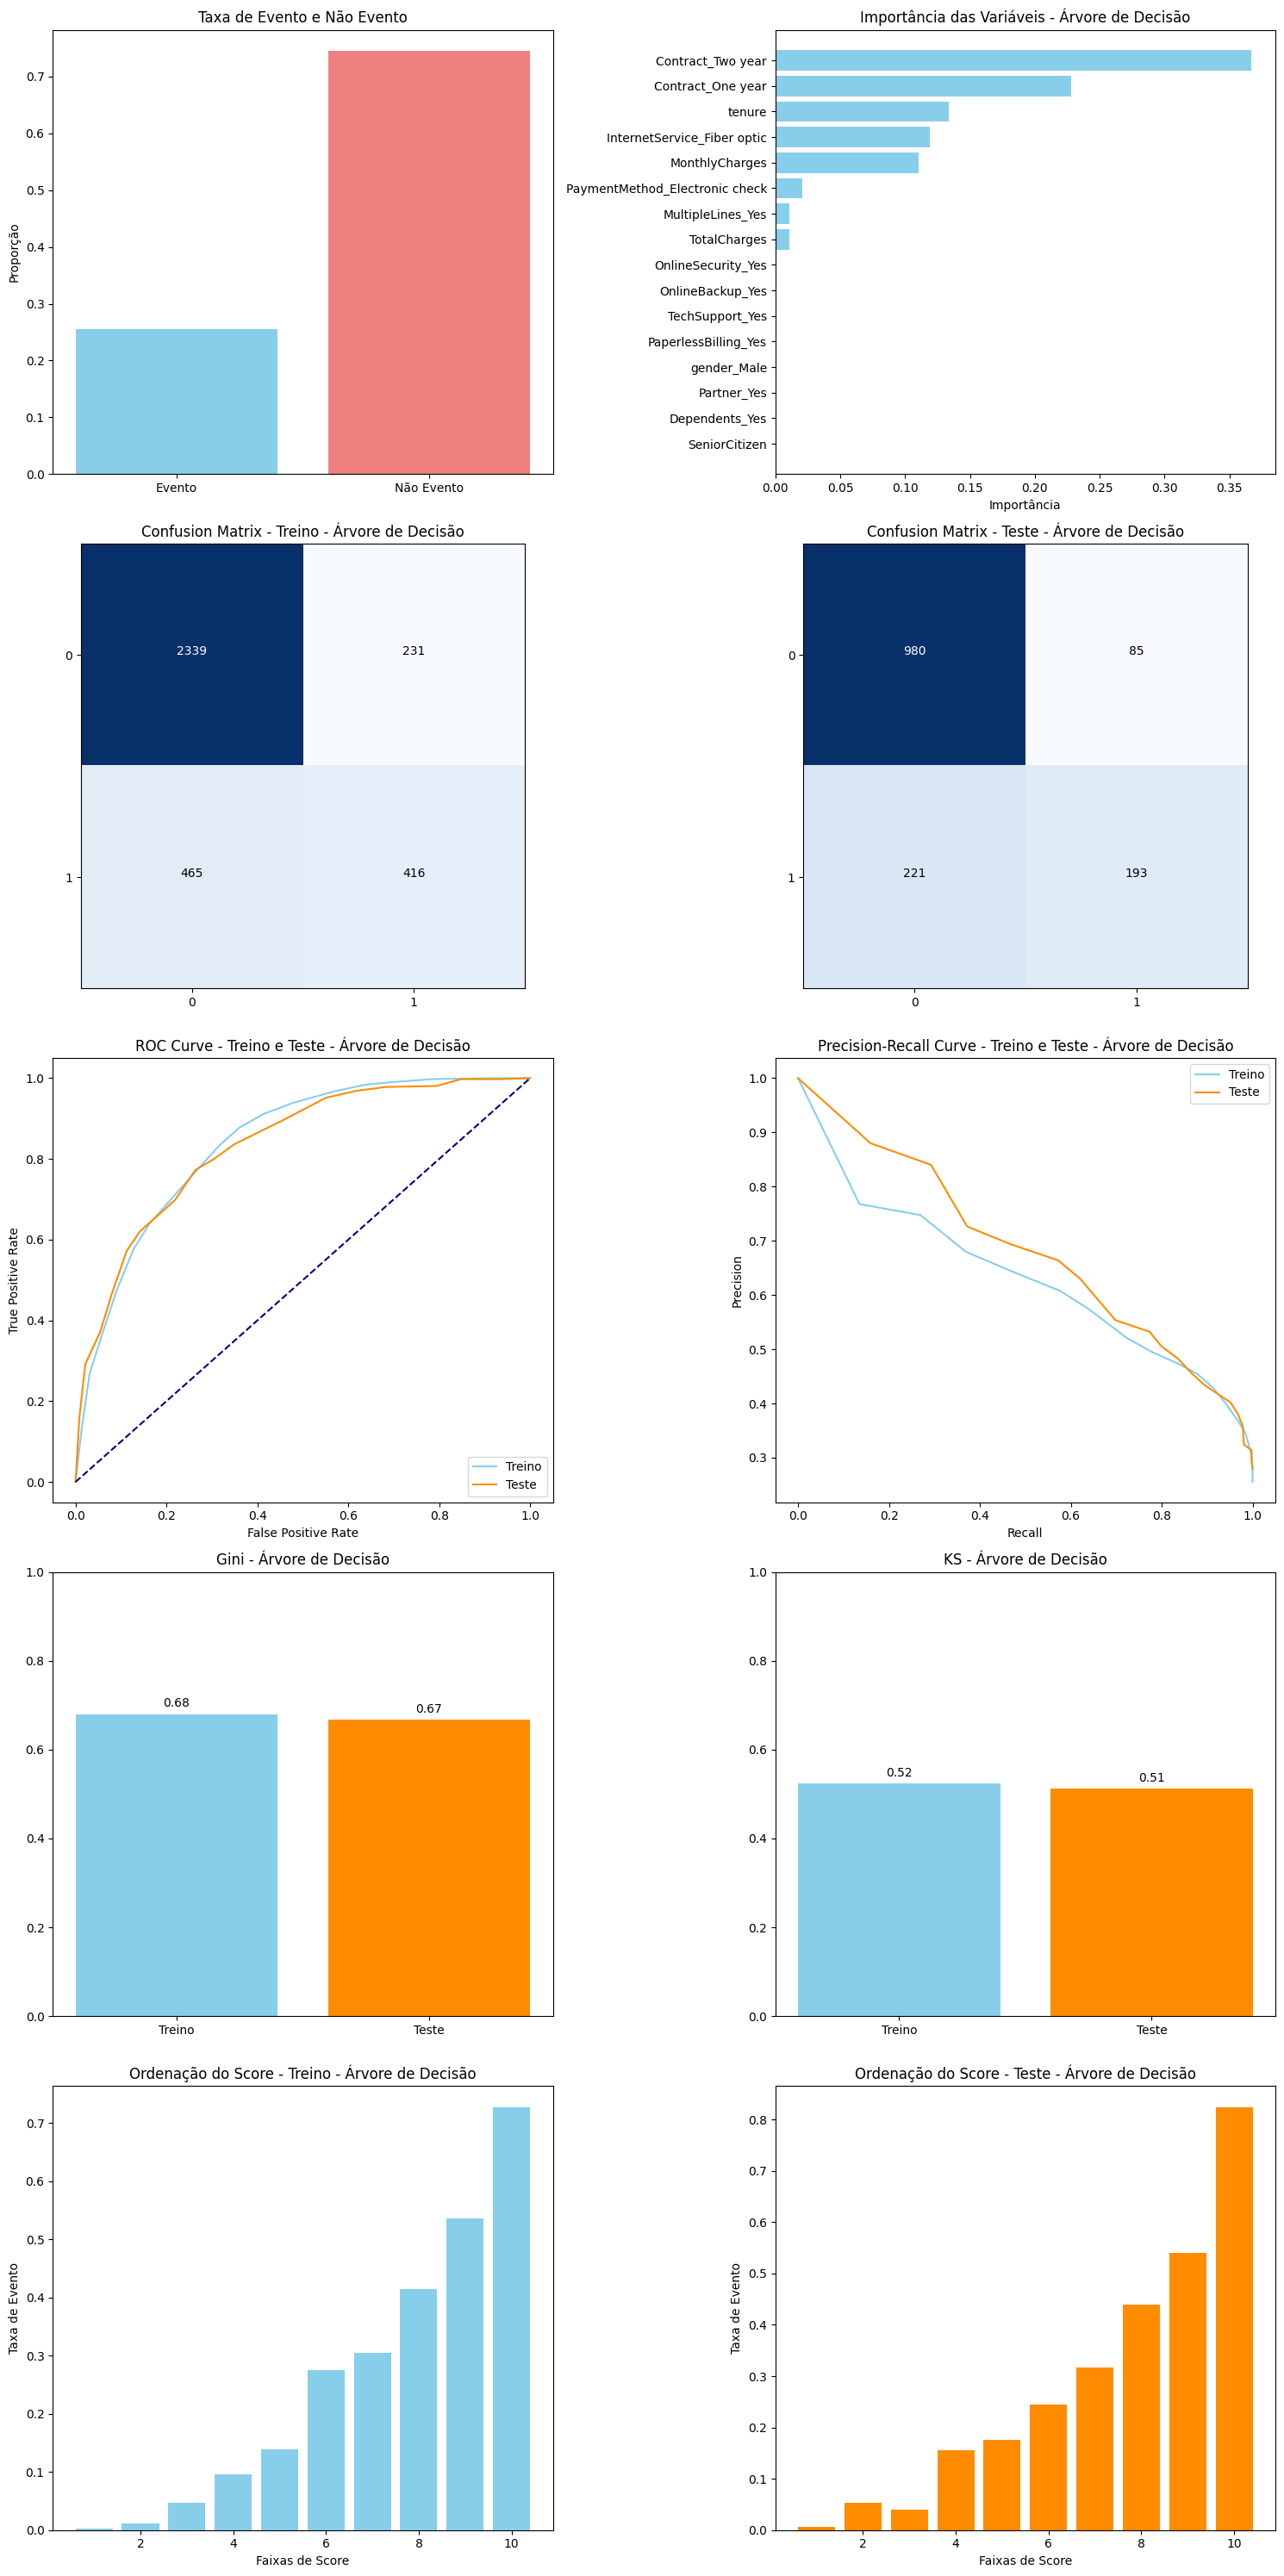

In [ ]:
avaliar_modelo(X_train, y_train, X_test, y_test, best_model_dt,nm_modelo='Árvore de Decisão')


**2.2. Regressão Logística**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np

# Definindo o modelo
model = LogisticRegression(max_iter=100)
model_sgs = LogisticRegression(max_iter=100)

# Definindo os parâmetros para o grid search
param_grid = {
    'penalty':['l1','l2'],
    'tol':[0.00001,0.0001,0.001],
    'C': [1.0, 2.0],
    'solver':['liblinear', 'saga'],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 2, 1: 1}]
}


# Calculando a quantidade total de modelos que serão treinados
num_models = len(param_grid['penalty']) * len(param_grid['tol']) * len(param_grid['C']) * len(param_grid['solver']) * 5  # 5 é o número de folds na validação cruzada (cv)
print(f"Total de Modelos a serem Treinados: {num_models}")

# Definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    scoring='roc_auc',  # 'accuracy' 'precision' 'recall' 'f1'
                    n_jobs=-1)

# Treinando o modelo com o grid search
grid.fit(X_train, y_train)

# treinando modelo sem grid search para comparra
model_sgs.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)

# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)

predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(gini_normalizado(y_test, predprob[:, 1]),2)
print('Gini normalizado --> ',gini_n)

best_model_rl = grid.best_estimator_



Total de Modelos a serem Treinados: 120
Melhores Parâmetros:  {'C': 2.0, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga', 'tol': 1e-05}
Melhor AUC:  0.8292064615021815
Gini normalizado -->  0.69


/tmp/ipython-input-652431358.py:124: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_analysis = y_test.groupby(deciles).mean()
/tmp/ipython-input-652431358.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_analysis_train = y_train.groupby(deciles_train).mean()


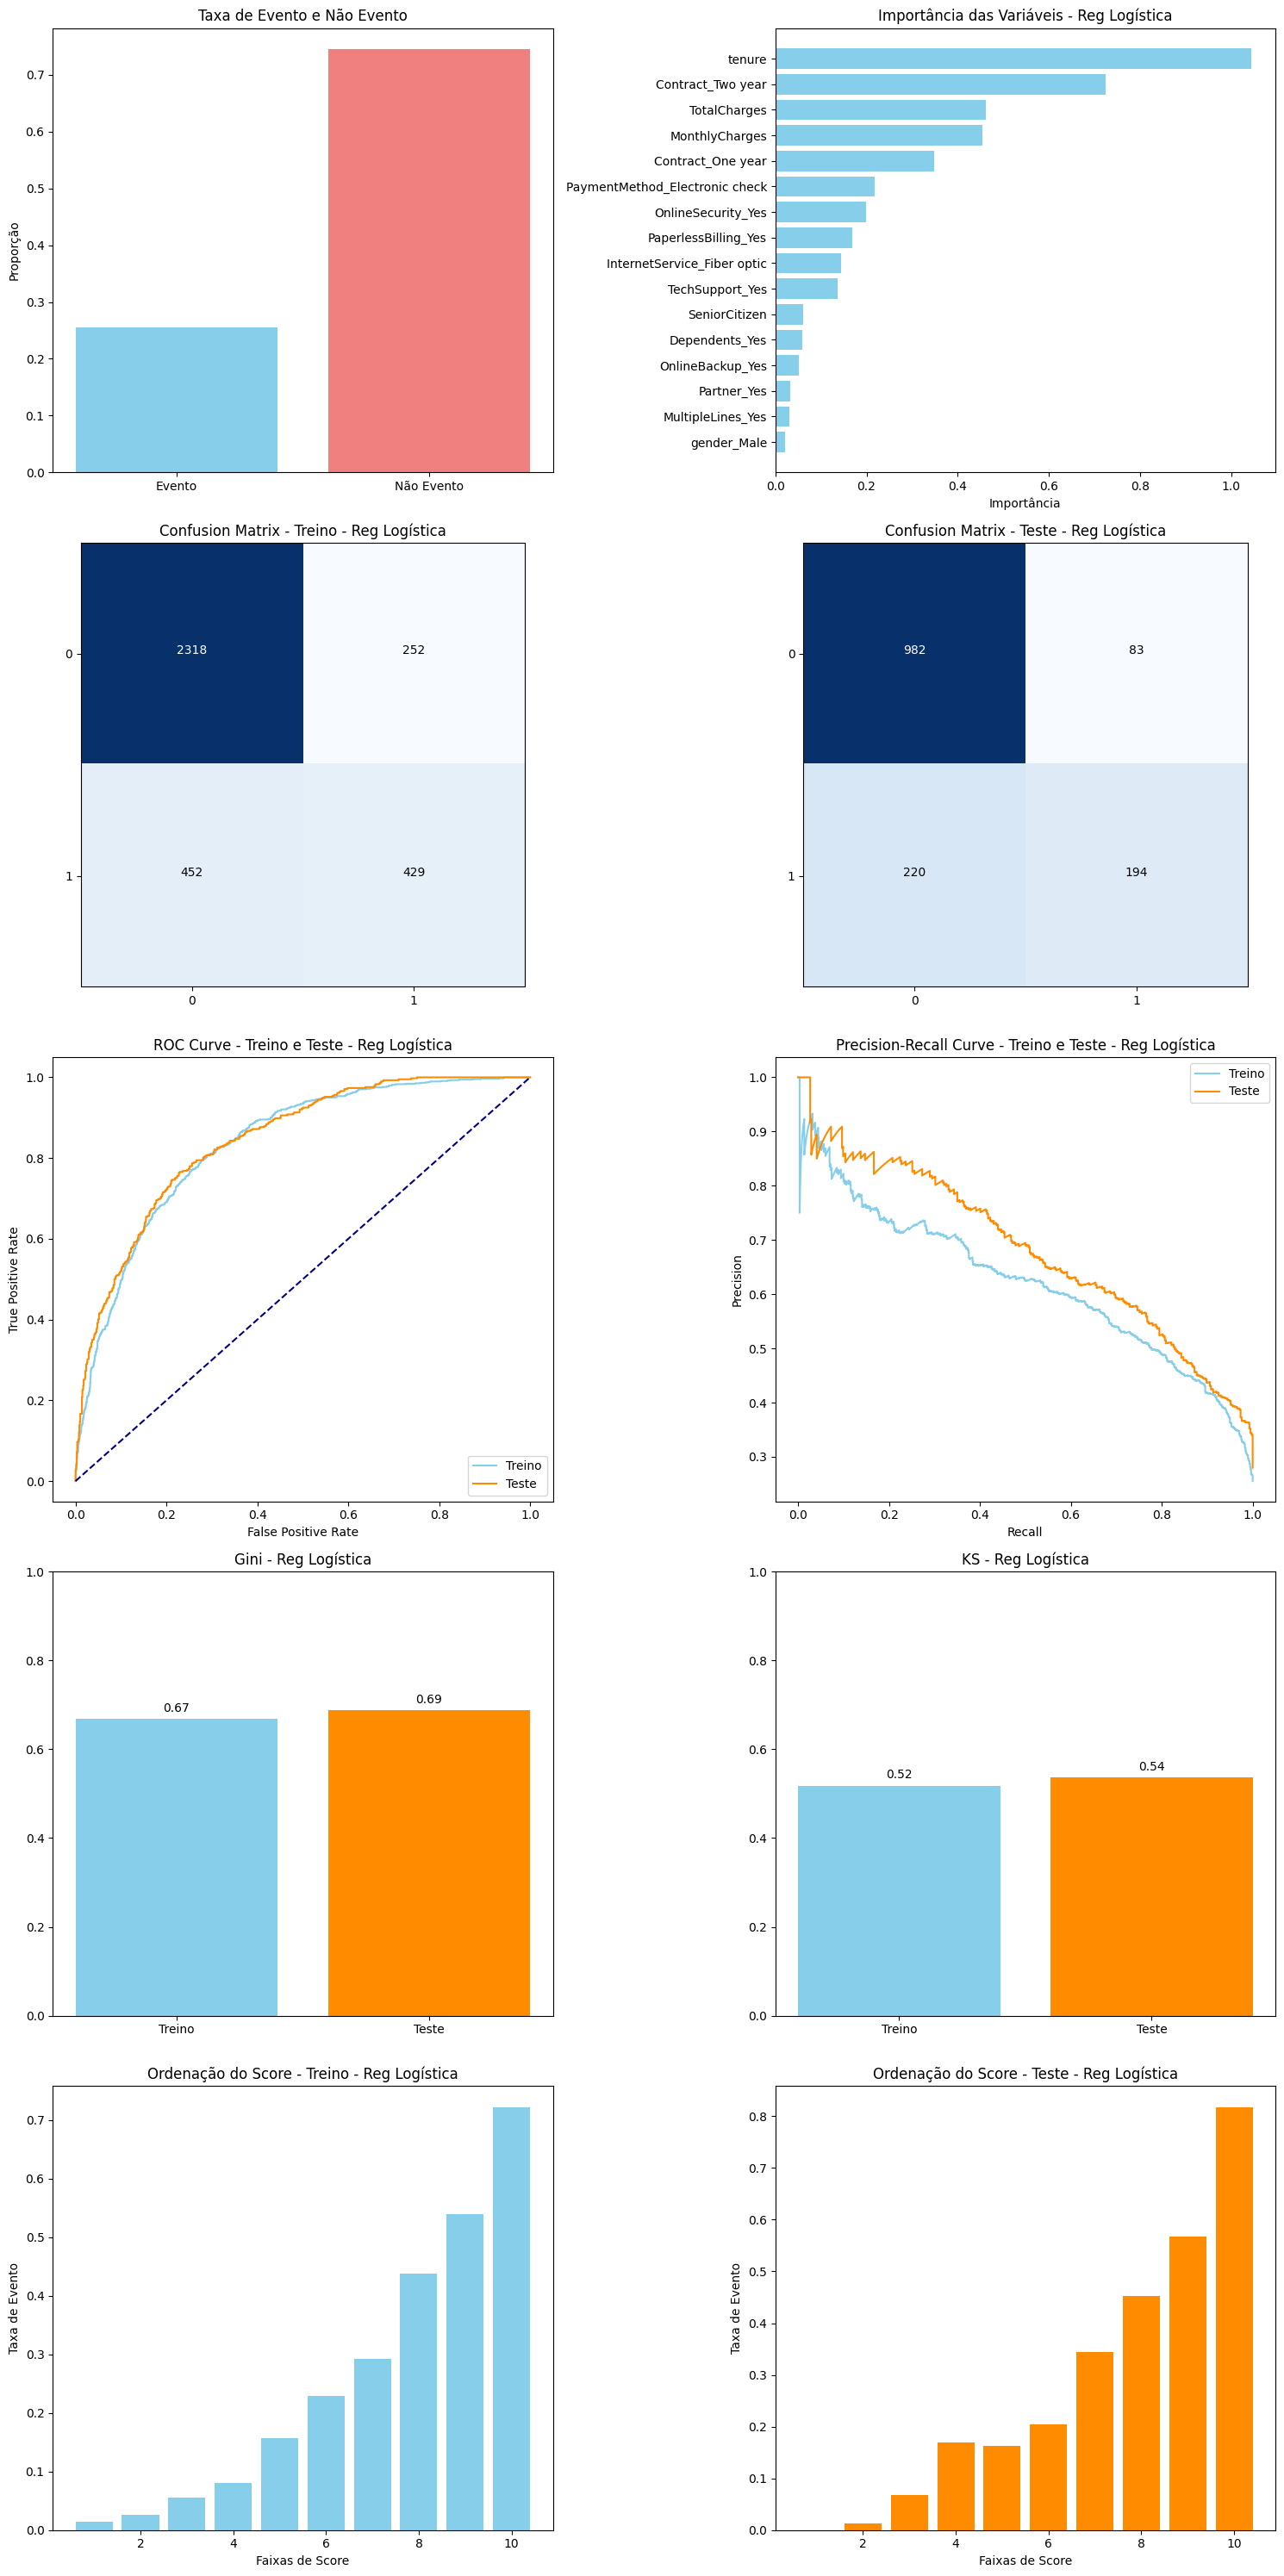

In [ ]:
avaliar_modelo(X_train, y_train, X_test, y_test, model_sgs,nm_modelo='Reg Logística')


**2.3. Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# Definindo o modelo
model = RandomForestClassifier()

# Definindo os parâmetros para o grid search
param_grid = {
    'n_estimators': [10, 50,100],
    'max_depth': [2, 3, 5],
    'min_samples_split': [0.001, 0.01],
    'min_samples_leaf': [2, 0.01],
    'bootstrap': [True, False],
    # 'max_features': ['auto', 'sqrt', 'log2']
}

# Definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    verbose=2,
                    scoring='roc_auc',  # 'accuracy' 'precision' 'recall' 'f1'
                    n_jobs=-1)

# Treinando o modelo com o grid search
grid.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)

# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)

predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(gini_normalizado(y_test, predprob[:, 1]),2)
print('Gini normalizado --> ',gini_n)

best_model_rf = grid.best_estimator_


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Melhores Parâmetros:  {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 0.001, 'n_estimators': 100}
Melhor AUC:  0.8325557852148073
Gini normalizado -->  0.69


/tmp/ipython-input-652431358.py:124: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_analysis = y_test.groupby(deciles).mean()
/tmp/ipython-input-652431358.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_analysis_train = y_train.groupby(deciles_train).mean()


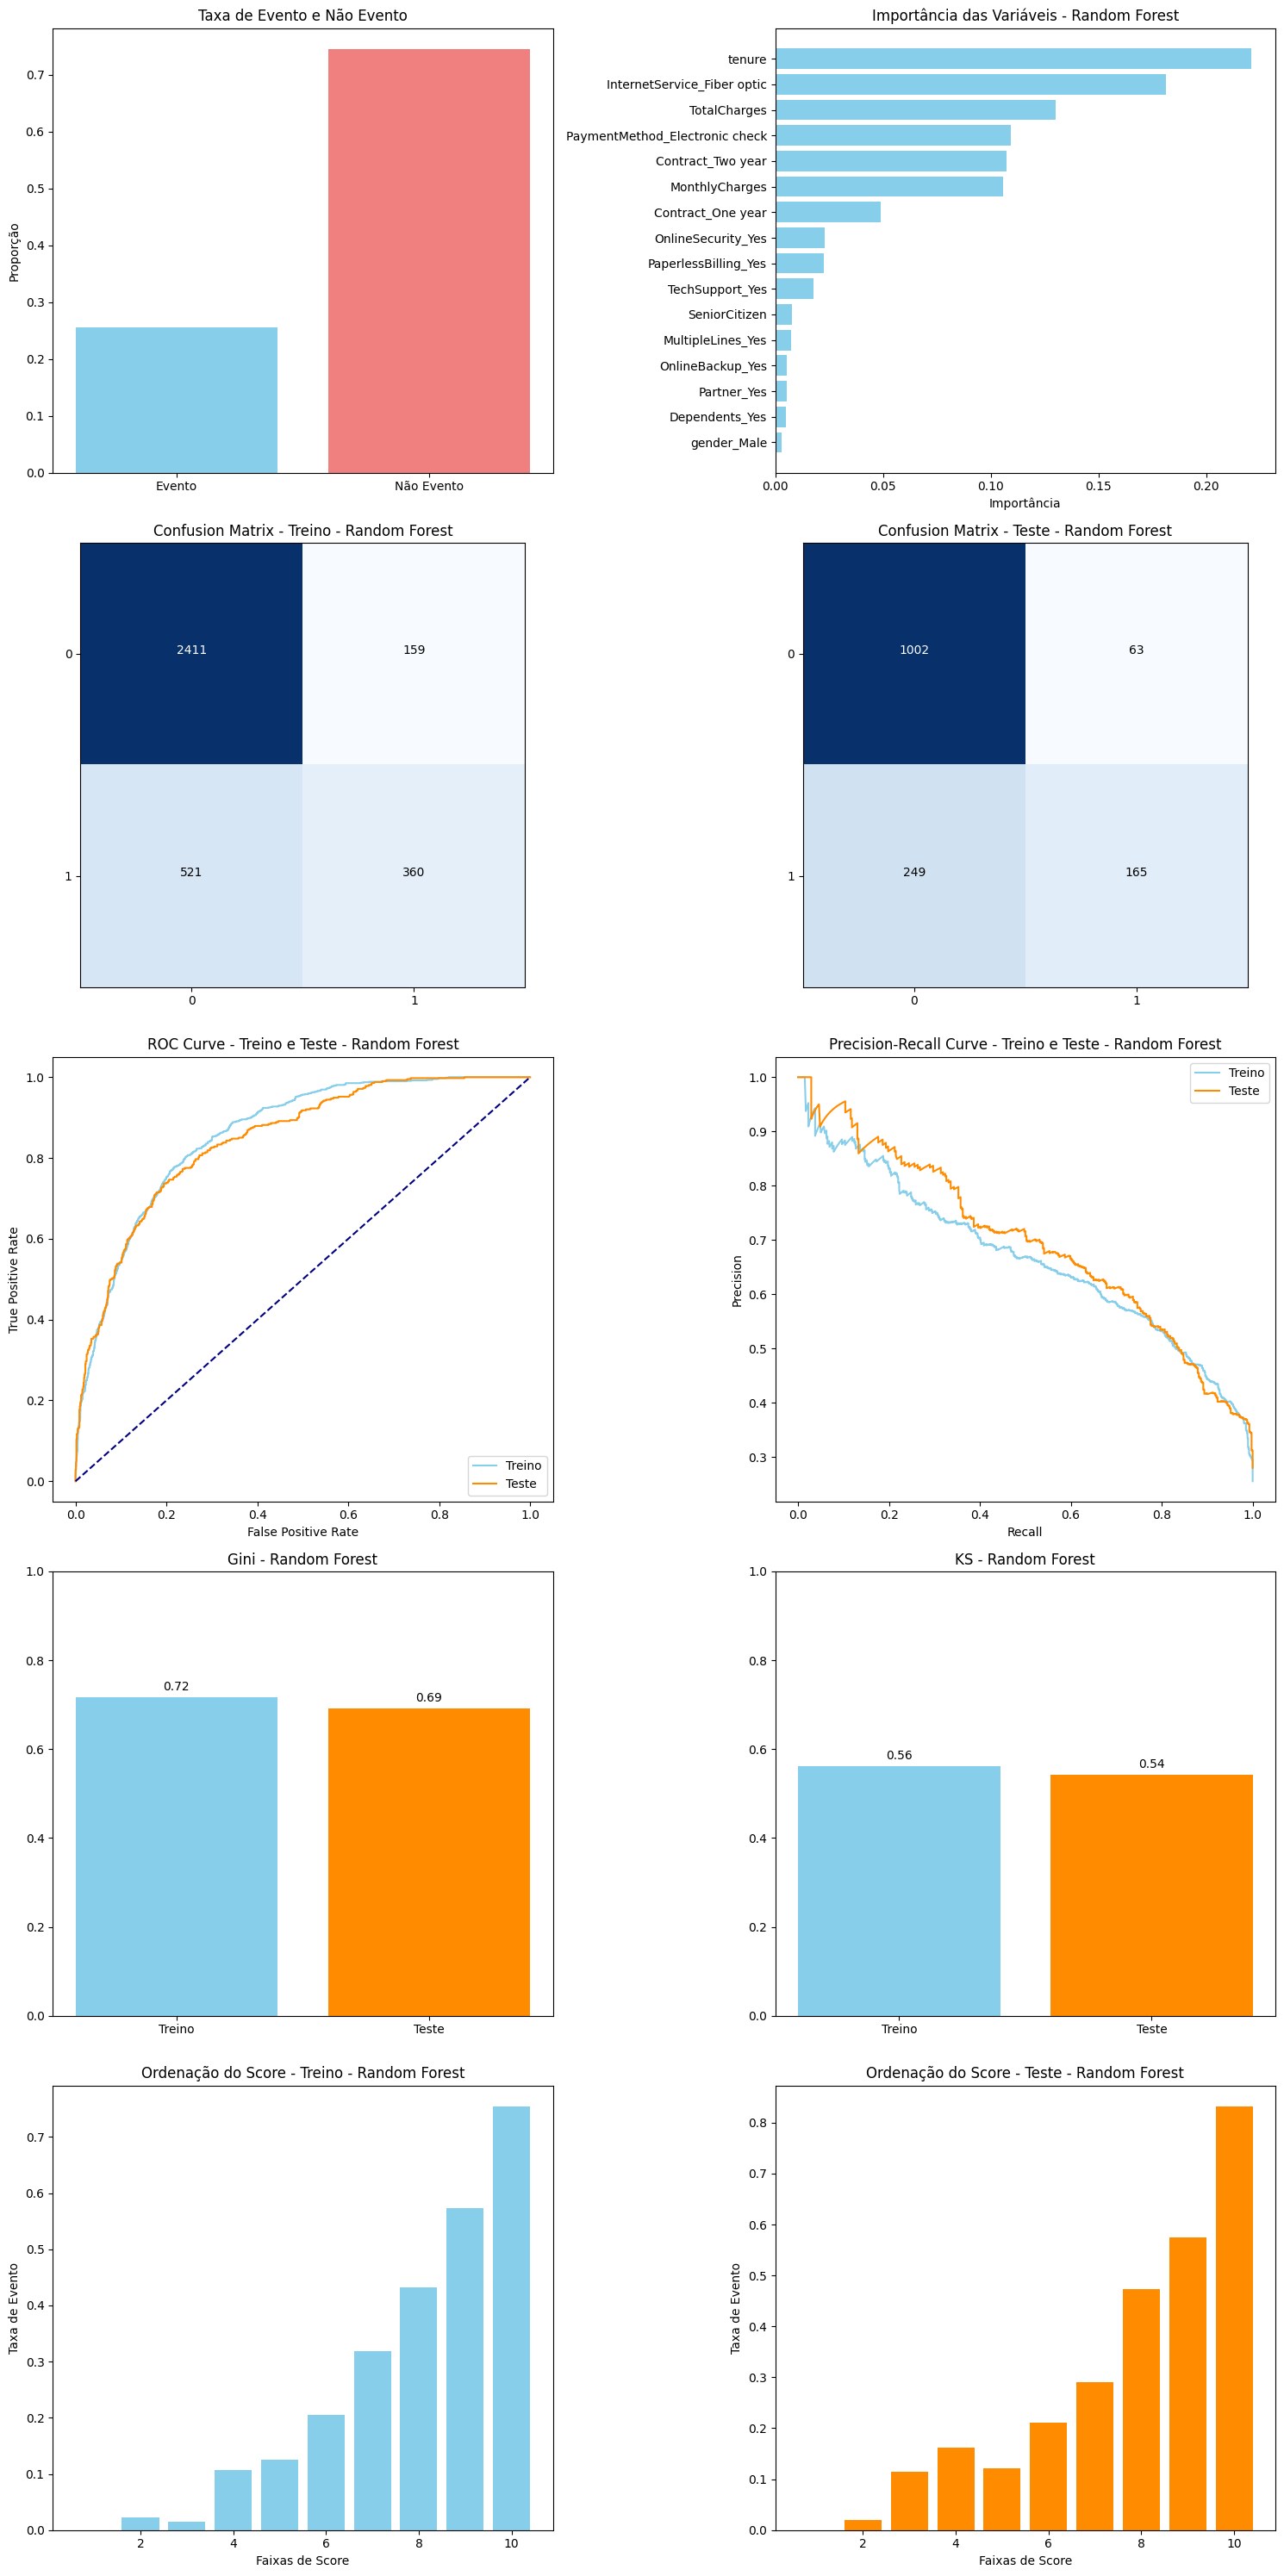

In [ ]:
avaliar_modelo(X_train, y_train, X_test, y_test, best_model_rf,nm_modelo='Random Forest')


**2.4. LightGBM**

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import numpy as np

# Definindo o modelo
model = lgb.LGBMClassifier()

# Definindo os parâmetros para o grid search
param_grid = {
    'max_depth': [3, 5, 7],
    'num_leaves': [5, 31],
    'reg_alpha': [0.1, 0.5],
    'force_col_wise': [True]
}

# Definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    verbose=2,
                    scoring='roc_auc',  # 'accuracy' 'precision' 'recall' 'f1'
                    n_jobs=-1)

# Treinando o modelo com o grid search
grid.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)

# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)

predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(gini_normalizado(y_test, predprob[:, 1]),2)
print('Gini normalizado --> ',gini_n)

best_model_lightgbm = grid.best_estimator_



Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 881, number of negative: 2570
[LightGBM] [Info] Total Bins 623
[LightGBM] [Info] Number of data points in the train set: 3451, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.255288 -> initscore=-1.070604
[LightGBM] [Info] Start training from score -1.070604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Melhores Parâmetros:  {'force_col_wise': True, 'max_depth': 3, 'num_leaves': 5, 'reg_alpha': 0.1}
Melhor AUC:  0.831365350064651
Gini normalizado -->  0.69


/tmp/ipython-input-652431358.py:124: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_analysis = y_test.groupby(deciles).mean()
/tmp/ipython-input-652431358.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_analysis_train = y_train.groupby(deciles_train).mean()


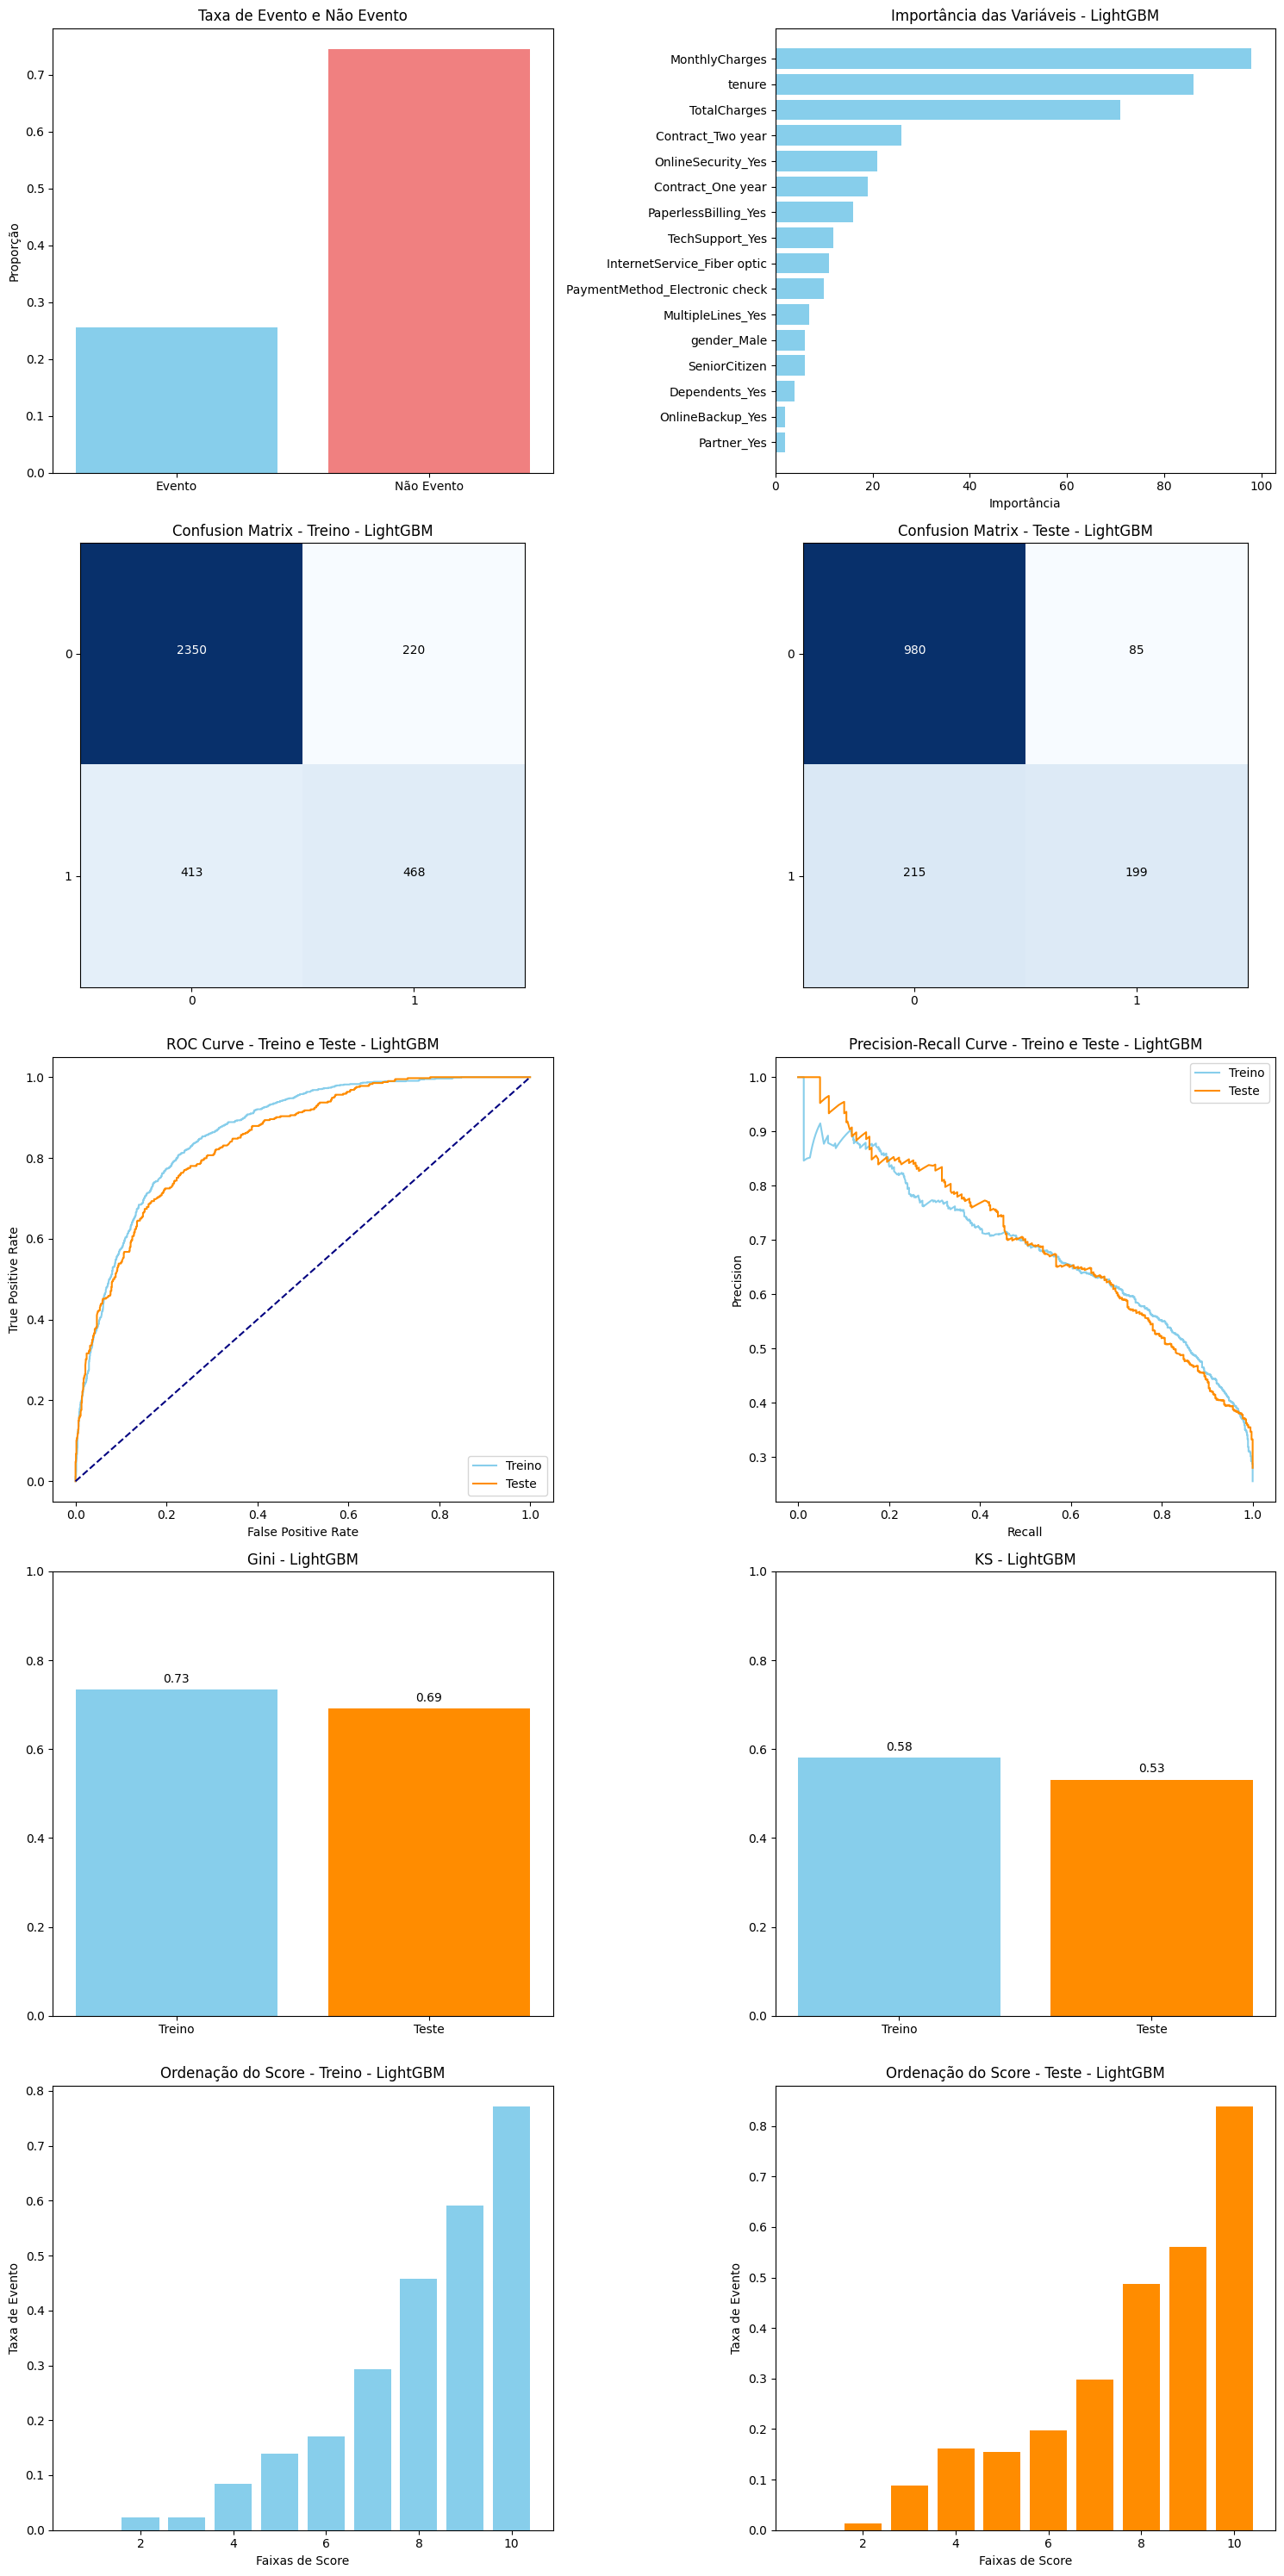

In [ ]:
avaliar_modelo(X_train, y_train, X_test, y_test, best_model_lightgbm,nm_modelo='LightGBM')


**3. Modelo Escolhido**

O modelo selecionado para este projeto foi o LightGBM, reconhecido pela eficiência em ordenar corretamente as probabilidades de churn, o que permite identificar com precisão os clientes mais suscetíveis e os menos propensos a abandonar o serviço.

Seu desempenho elevado na métrica AUC confirma a capacidade do modelo em separar com clareza os casos positivos (clientes churn) dos negativos (clientes que permanecem).

Na análise da matriz de confusão, o LightGBM se destacou por reduzir falsos positivos e manter boa taxa de verdadeiros negativos. Esse resultado é especialmente relevante no contexto de negócio: como decisões de investimento em marketing seriam tomadas a partir das previsões, minimizar falsos positivos significa evitar gastos desnecessários com clientes que, na prática, não iriam se tornar churn.

Outro ponto importante é a consistência observada nas métricas KS, Gini e AUC entre as bases de treino e teste, indicando ausência de overfitting e assegurando robustez e boa capacidade de generalização. Assim, o LightGBM se mostra a opção mais adequada, combinando eficácia preditiva e confiabilidade para apoiar decisões estratégicas.


**4. Salvar artefatos dos modelos**

Após o treinamento, é fundamental salvar os objetos gerados (modelos e transformadores) para garantir reprodutibilidade e possibilitar o uso em novas previsões sem necessidade de reprocessar todo o pipeline.

In [ ]:
import pickle

with open('/content/drive/MyDrive/Colab Notebooks/Projetos/Predicao de Churn - Empresa Telecom/03 - Modelagem/best_model_dt.pkl', 'wb') as file:
  pickle.dump(best_model_dt, file)

with open('/content/drive/MyDrive/Colab Notebooks/Projetos/Predicao de Churn - Empresa Telecom/03 - Modelagem/best_model_rl.pkl', 'wb') as file:
  pickle.dump(best_model_rl, file)

with open('/content/drive/MyDrive/Colab Notebooks/Projetos/Predicao de Churn - Empresa Telecom/03 - Modelagem/best_model_rf.pkl', 'wb') as file:
  pickle.dump(best_model_rf, file)

with open('/content/drive/MyDrive/Colab Notebooks/Projetos/Predicao de Churn - Empresa Telecom/03 - Modelagem/best_model_lightgbm.pkl', 'wb') as file:
  pickle.dump(best_model_lightgbm, file)


#**Conclusão**

Os resultados da etapa de modelagem mostraram que os algoritmos testados — Árvore de Decisão, Regressão Logística, Random Forest e LightGBM — foram capazes de capturar padrões relevantes no comportamento de churn, cada um com seus pontos fortes. Enquanto os modelos mais simples, como a Regressão Logística, ofereceram maior interpretabilidade, os baseados em árvores, especialmente o Random Forest e o LightGBM, apresentaram melhor desempenho em métricas discriminativas como AUC e KS, demonstrando maior poder preditivo.

Com essa análise, fica clara a robustez do pipeline construído e a viabilidade de aplicar o modelo em situações reais. A próxima etapa será a escoragem, na qual o modelo escolhido será utilizado para atribuir probabilidades de churn a cada cliente. Esse processo permitirá identificar de forma prática quais clientes estão mais propensos à evasão, fornecendo um instrumento direto para apoiar estratégias de retenção e tomada de decisão.